In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from dataclasses import dataclass
from pathlib import Path
import yaml

from omegaconf import OmegaConf, DictConfig
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
import torch
from tqdm.auto import tqdm

from src.analysis.state_space import StateSpaceAnalysisSpec
from src.analysis.trf import trf_to_df
from src.encoding.ecog.timit import OutFile
from src.encoding.ecog import timit as timit_encoding, get_electrode_df, \
     AlignedECoGDataset, ContrastiveModelSnapshot, epoch_by_state_space

In [42]:
dataset = "timit"
subject = "EC196"

In [43]:
# cd ../..

In [44]:
ttest_df = pd.read_csv("ttest_results_filtered.csv", index_col=["dataset", "subject", "model2", "model1", "output_dim"])
ttest_df["log_pval"] = np.log10(ttest_df["pval"])
ttest_df

output_dim.1 permutation  \
dataset subject model2        model1   output_dim                             
timit   EC212   phoneme       baseline 201                  201       shift   
        EC260   biphone_pred  baseline 206                  206       shift   
                biphone_recon baseline 206                  206       shift   
        EC212   biphone_pred  baseline 201                  201       shift   
        EC260   phoneme       baseline 206                  206       shift   
...                                                         ...         ...   
        EC183   biphone_pred  baseline 69                    69       shift   
                syllable      baseline 51                    51       units   
        EC196   next_phoneme  baseline 85                    85       shift   
        EC195   biphone_recon baseline 28                    28       shift   
        EC260   biphone_pred  baseline 202                  202       shift   

                                                          tval          pval  \
dataset subject model2        model1   output_dim                              
timit   EC212   phoneme       baseline 201         1051.367209  4.910559e-12   
        EC260   biphone_pred  baseline 206          800.648723  1.460087e-11   
                biphone_recon baseline 206          789.107130  1.547400e-11   
        EC212   biphone_pred  baseline 201          574.341928  5.513919e-11   
        EC260   phoneme       baseline 206          572.531062  5.584010e-11   
...                                                        ...           ...   
        EC183   biphone_pred  baseline 69             8.762419  9.350969e-04   
                syllable      baseline 51             8.708415  9.575238e-04   
        EC196   next_phoneme  baseline 85             8.695729  9.628882e-04   
        EC195   biphone_recon baseline 28             8.689139  9.656896e-04   
        EC260   biphone_pred  baseline 202            8.672717  9.727148e-04   

                                                    log_pval  
dataset subject model2        model1   output_dim             
timit   EC212   phoneme       baseline 201        -11.308869  
        EC260   biphone_pred  baseline 206        -10.835621  
                biphone_recon baseline 206        -10.810397  
        EC212   biphone_pred  baseline 201        -10.258540  
        EC260   phoneme       baseline 206        -10.253054  
...                                                      ...  
        EC183   biphone_pred  baseline 69          -3.029143  
                syllable      baseline 51          -3.018850  
        EC196   next_phoneme  baseline 85          -3.016424  
        EC195   biphone_recon baseline 28          -3.015162  
        EC260   biphone_pred  baseline 202         -3.012014  

[637 rows x 5 columns]

In [45]:
encoder_dirs = list(Path("outputs/encoders").glob(f"{dataset}/*/{subject}"))
encoders = {encoder_dir.parent.name: torch.load(encoder_dir / "model.pkl")
            for encoder_dir in encoder_dirs}

In [46]:
encoder_names = sorted(encoders.keys())
encoder_names

['baseline',
 'biphone_pred',
 'biphone_recon',
 'next_phoneme',
 'phoneme',
 'random8',
 'syllable',
 'word_broad']

In [47]:
# Just need a random config in order to extract relevant paths and get outfile
baseline_path = next(iter(path for path in encoder_dirs if "phoneme" == path.parent.name))
with (baseline_path / ".hydra" / "config.yaml").open() as f:
    baseline_config = OmegaConf.create(yaml.safe_load(f))
out = timit_encoding.prepare_out_file(baseline_config, next(iter(baseline_config.data)))

In [48]:
snapshot = ContrastiveModelSnapshot.from_config(baseline_config, next(iter(baseline_config.feature_sets.model_features.values())))

In [49]:
aligned = AlignedECoGDataset(snapshot, out)

Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

In [50]:
electrode_df = pd.read_csv(encoder_dirs[0] / "electrodes.csv")
electrode_df

,electrode_idx,electrode_name,long_name,type,roi
0,0,GP1,GridPosterior1,grid,fusiform
1,1,GP2,GridPosterior2,grid,fusiform
2,2,GP3,GridPosterior3,grid,middletemporal
3,3,GP4,GridPosterior4,grid,middletemporal
4,4,GP5,GridPosterior5,grid,middletemporal
...,...,...,...,...,...
303,303,HD6,Hippocampus6,depth,Left-Cerebral-White-Matter
304,304,HD7,Hippocampus7,depth,Left-Cerebral-White-Matter
305,305,HD8,Hippocampus8,depth,Left-Cerebral-White-Matter
306,306,HD9,Hippocampus9,depth,Left-Cerebral-White-Matter


In [51]:
coef_dfs = {model_name: trf_to_df(encoder, electrode_df.electrode_name[:256])
            for model_name, encoder in tqdm(encoders.items())}
coef_df = pd.concat(coef_dfs, names=["model"]).droplevel(1)
coef_df

  0%|          | 0/8 [00:00<?, ?it/s]

,feature,output_name,input_dim,output_dim,lag,time,coef
model,,,,,,,
syllable,onset,GP1,0,0,0,0.00,-0.000050
syllable,onset,GP1,0,0,1,0.01,0.000032
syllable,onset,GP1,0,0,2,0.02,0.000389
syllable,onset,GP1,0,0,3,0.03,0.000442
syllable,onset,GP1,0,0,4,0.04,0.000438
...,...,...,...,...,...,...,...
word_broad,model_embedding_7,GA128,20,255,56,0.56,0.000238
word_broad,model_embedding_7,GA128,20,255,57,0.57,0.000262
word_broad,model_embedding_7,GA128,20,255,58,0.58,0.000259


In [52]:
all_trf_features = coef_df.feature.unique()
all_trf_features

array(['onset', 'phnfeatConsOnset_0', 'phnfeatConsOnset_1',
       'phnfeatConsOnset_2', 'phnfeatConsOnset_3', 'phnfeatConsOnset_4',
       'phnfeatConsOnset_5', 'maxDtL', 'formantMedOnset_0',
       'formantMedOnset_1', 'formantMedOnset_2', 'formantMedOnset_3',
       'F0', 'model_embedding_0', 'model_embedding_1',
       'model_embedding_2', 'model_embedding_3', 'model_embedding_4',
       'model_embedding_5', 'model_embedding_6', 'model_embedding_7'],
      dtype=object)

In [53]:
phonetic_features = [f"phnfeatConsOnset_{i}" for i in range(6)]
phonetic_features += [f"formantMedOnset_{i}" for i in range(4)]

### Compute epoched HGA

In [54]:
# hack together a new state space spec for sentence onset
# nb state space bounds are inclusive, so we need to subtract 1 from the end of each bound
trial_spec = StateSpaceAnalysisSpec(
    aligned.total_num_frames,
    ["trial"],
    [sorted([(start, end - 1) for start, end in aligned.name_to_frame_bounds.values()])],
)
aligned._snapshot.all_state_spaces["trial"] = trial_spec

In [55]:
trial_epochs = epoch_by_state_space(
    aligned, "trial",
    epoch_window=(-0.1, 1.),
    baseline_window=(-0.1, 0.),
    return_df=True)
trial_epochs.head(3)

  0%|          | 0/580 [00:00<?, ?it/s]

,epoch_idx,electrode_idx,epoch_sample,value,epoch_time,epoch_label,epoch_duration_samples,name,item_idx,trial_idx,state_space,label_idx,instance_idx,span_secs,span_model_frames,span_ecog_samples,span_ecog_samples_nopad,item_start_frame,item_end_frame,epoch_duration_secs
0,0,0,0,-1.013292,-0.1,trial,110,fadg0_si1279,5252,0,trial,0,426,"(0.0, 1.7974291666666669)","(0, 89)","(50, 229)","(0, 179)",803496,803586,1.1
1,0,1,0,0.124847,-0.1,trial,110,fadg0_si1279,5252,0,trial,0,426,"(0.0, 1.7974291666666669)","(0, 89)","(50, 229)","(0, 179)",803496,803586,1.1
2,0,2,0,1.504887,-0.1,trial,110,fadg0_si1279,5252,0,trial,0,426,"(0.0, 1.7974291666666669)","(0, 89)","(50, 229)","(0, 179)",803496,803586,1.1


### Plotting prep

In [56]:
model_color_norm = plt.Normalize(0, len(encoder_names))
model_color_mapper = plt.colormaps["tab10"]
get_model_color = lambda model_name: model_color_mapper(model_color_norm(encoder_names.index(model_name)))

### Correspondences between electrodes significant under different models

In [57]:
log_pvals = ttest_df.loc[dataset, subject].pivot_table(values="log_pval", index="model2", columns="output_dim").fillna(0)
log_pvals

/tmp/ipykernel_185243/3930710449.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  log_pvals = ttest_df.loc[dataset, subject].pivot_table(values="log_pval", index="model2", columns="output_dim").fillna(0)


output_dim,10,17,20,21,40,55,62,71,72,83,...,205,210,212,215,220,228,232,239,246,250
model2,,,,,,,,,,,,,,,,,,,,,
biphone_pred,0.00000,0.000000,0.000000,0.000000,0.000000,-3.048015,0.000000,-4.029578,-3.193678,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
biphone_recon,0.00000,0.000000,0.000000,0.000000,-3.576996,-3.970133,-5.055117,-3.228679,-4.646497,0.000000,...,-4.489239,-3.727272,0.000000,-5.425015,0.00000,-3.511372,-3.908889,0.000000,-6.028129,0.000000
next_phoneme,-3.91078,-3.057127,0.000000,0.000000,0.000000,0.000000,0.000000,-3.084637,0.000000,-3.977236,...,0.000000,0.000000,0.000000,-5.136592,-3.36695,0.000000,0.000000,0.000000,0.000000,0.000000
phoneme,0.00000,0.000000,0.000000,0.000000,0.000000,-4.653252,0.000000,0.000000,-4.076245,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
random8,0.00000,0.000000,0.000000,0.000000,-3.393599,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-3.766002,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,-3.503617
syllable,0.00000,0.000000,-3.302032,-3.542054,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,-3.319247,0.000000,0.000000
word_broad,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000


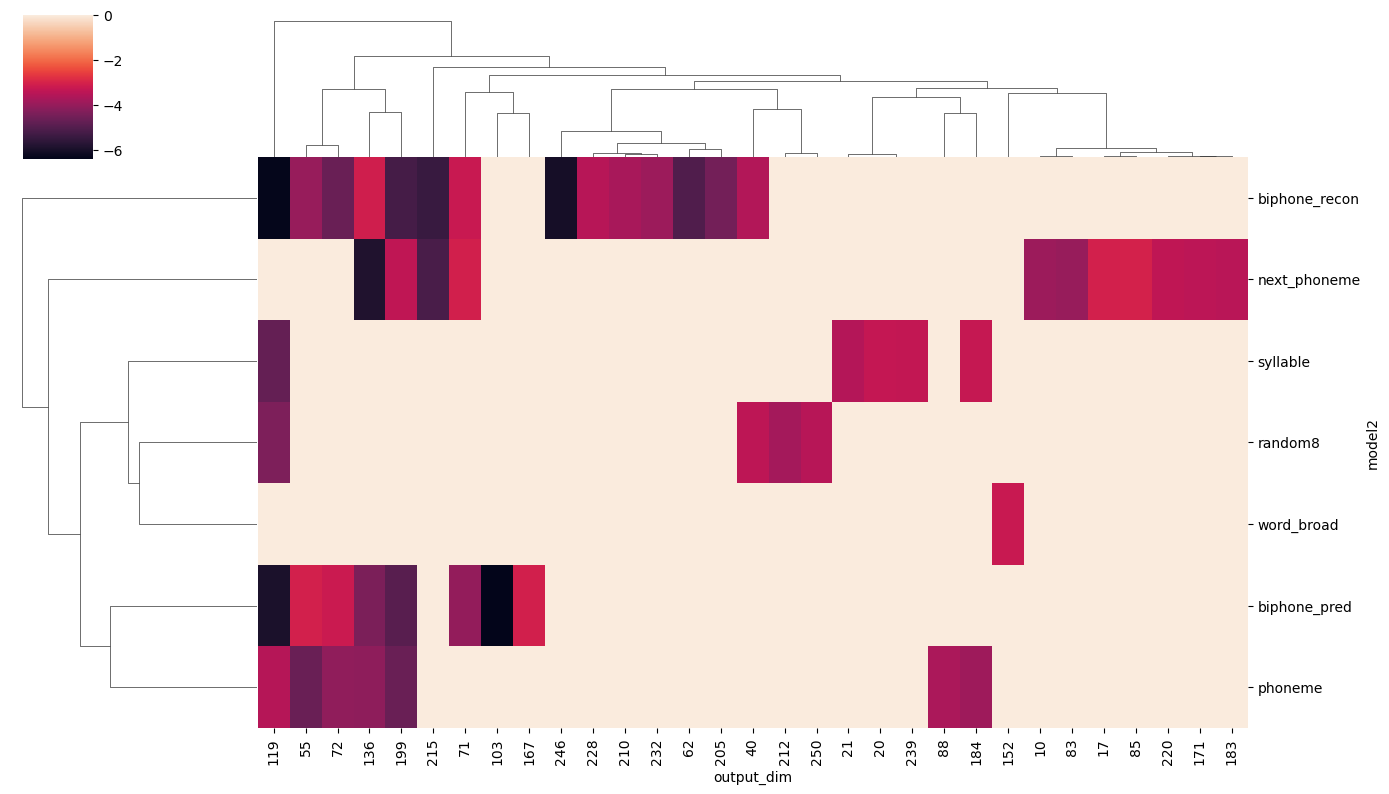

In [58]:
sns.clustermap(log_pvals, vmax=0, xticklabels=1, figsize=(14, 8))

### Colocation of model embedding and TRF weights

Which electrodes demonstrate simultaneous activation in response to acoustic-phonetic weights and also model embeddings?

In [59]:
study_model = "syllable"
study_coef = coef_df.loc["baseline"].reset_index().set_index("output_dim")
study_coef["feature_is_phonetic"] = study_coef.feature.isin(phonetic_features)
study_coef["feature_is_prosodic"] = study_coef.feature.isin(("F0", "maxDtL"))
study_coef["significantly_predicted"] = False
study_coef.loc[ttest_df.loc[dataset, subject, study_model].droplevel("model1").index, "significantly_predicted"] = True

study_coef

/tmp/ipykernel_185243/3018524602.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  study_coef.loc[ttest_df.loc[dataset, subject, study_model].droplevel("model1").index, "significantly_predicted"] = True


,model,feature,output_name,input_dim,lag,time,coef,feature_is_phonetic,feature_is_prosodic,significantly_predicted
output_dim,,,,,,,,,,
0,baseline,onset,GP1,0,0,0.00,-0.000027,False,False,False
0,baseline,onset,GP1,0,1,0.01,0.000060,False,False,False
0,baseline,onset,GP1,0,2,0.02,0.000402,False,False,False
0,baseline,onset,GP1,0,3,0.03,0.000447,False,False,False
0,baseline,onset,GP1,0,4,0.04,0.000451,False,False,False
...,...,...,...,...,...,...,...,...,...,...
255,baseline,F0,GA128,12,56,0.56,-0.000500,False,True,False
255,baseline,F0,GA128,12,57,0.57,-0.000095,False,True,False
255,baseline,F0,GA128,12,58,0.58,0.000257,False,True,False


In [60]:
ttest_df.loc[dataset, subject, study_model].droplevel("model1")

/tmp/ipykernel_185243/1248174574.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  ttest_df.loc[dataset, subject, study_model].droplevel("model1")


,output_dim.1,permutation,tval,pval,log_pval
output_dim,,,,,
119,119,units,23.615213,0.000019,-4.719790
21,21,units,11.884890,0.000287,-3.542054
239,239,units,10.418277,0.000479,-3.319247
20,20,shift,10.312387,0.000499,-3.302032
184,184,units,10.166932,0.000527,-3.278112


<Axes: xlabel='feature_is_phonetic', ylabel='coef'>

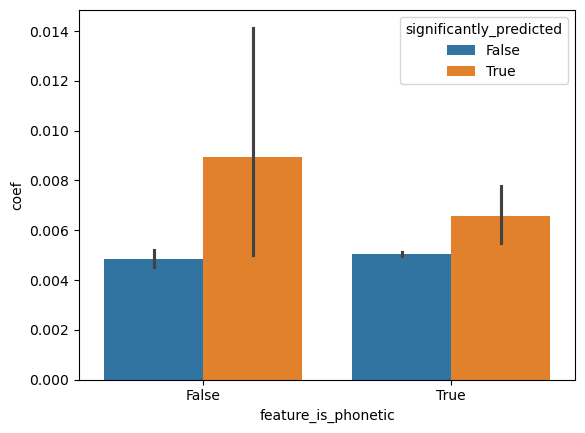

In [61]:
feature_norms_phonetic = study_coef.groupby(["feature", "output_dim", "feature_is_phonetic", "significantly_predicted"]).coef.apply(np.linalg.norm).to_frame("coef").reset_index()
sns.barplot(x="feature_is_phonetic", y="coef", hue="significantly_predicted", data=feature_norms_phonetic)

<Axes: xlabel='feature_is_prosodic', ylabel='coef'>

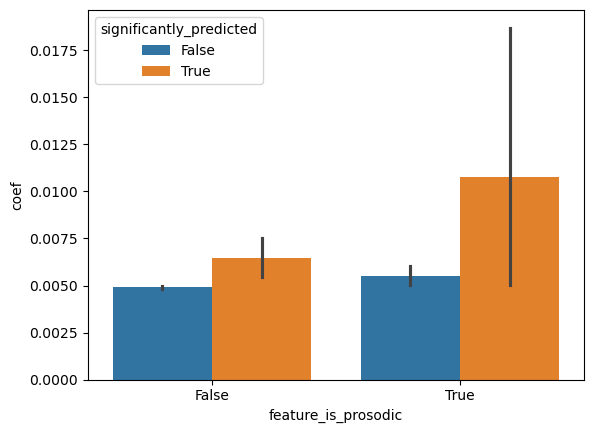

In [62]:
feature_norms_prosodic = study_coef.groupby(["feature", "output_dim", "feature_is_prosodic", "significantly_predicted"]).coef.apply(np.linalg.norm).to_frame("coef").reset_index()
sns.barplot(x="feature_is_prosodic", y="coef", hue="significantly_predicted", data=feature_norms_prosodic)

<Axes: xlabel='time', ylabel='coef'>

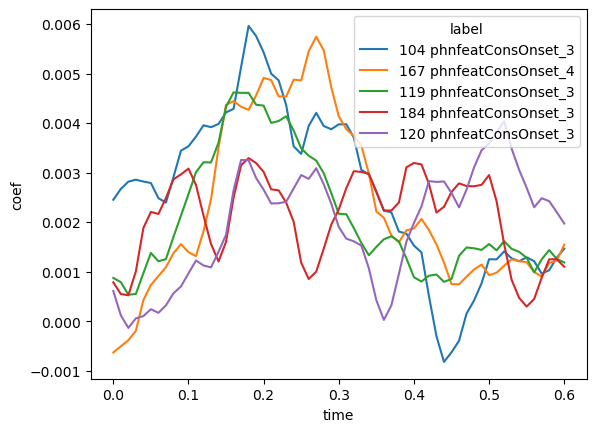

In [63]:
# Find largest-norm phonetic responses
plot_n = 5
max_norm_phonetic_responses = feature_norms_phonetic[feature_norms_phonetic.feature_is_phonetic == True].sort_values("coef", ascending=False).set_index(["output_dim", "feature"]).head(plot_n).index
plot_df = study_coef.set_index("feature", append=True).loc[max_norm_phonetic_responses].reset_index()
plot_df["label"] = plot_df.output_dim.astype(str) + " " + plot_df.feature
sns.lineplot(data=plot_df, x="time", y="coef", hue="label")

### Colocation of model embedding and onset electrodes

In [64]:
onset_coef_norm = study_coef[study_coef.feature == "onset"].groupby("output_dim") \
    .coef.apply(np.linalg.norm).sort_values(ascending=False)


/tmp/ipykernel_185243/2648713857.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_epochs["electrode_idx"] = plot_epochs.electrode_idx.astype(str)


<Axes: xlabel='epoch_time', ylabel='value'>

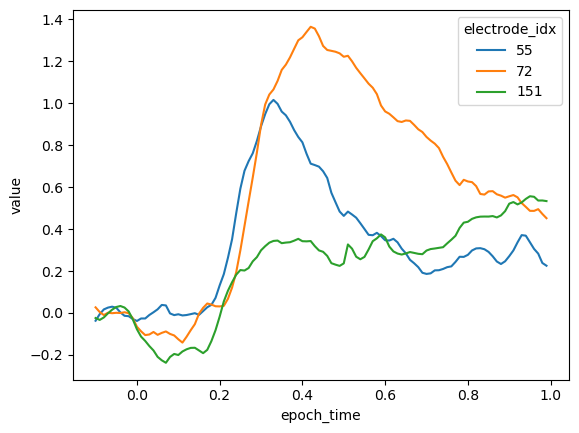

In [65]:
norm_threshold = 0.009
plot_epochs = trial_epochs[trial_epochs.electrode_idx.isin(onset_coef_norm[onset_coef_norm > norm_threshold].index)]
plot_epochs["electrode_idx"] = plot_epochs.electrode_idx.astype(str)
sns.lineplot(data=plot_epochs,
             x="epoch_time", y="value", hue="electrode_idx", errorbar=None)

In [66]:
# TODO ask across subject: does model embedding norm predict onset-like response or not?

In [67]:
embedding_coef_norms = coef_df[coef_df.feature.str.startswith("model_embedding")] \
    .groupby(["model", "output_dim", "feature"]).coef.apply(np.linalg.norm) \
    .groupby(["model", "output_dim"]).mean()
onset_embedding_coef_norms = pd.merge(
    onset_coef_norm, embedding_coef_norms, left_index=True, right_index=True,
    suffixes=("_onset", "_embedding"))
onset_embedding_coef_norms

coef_onset  coef_embedding
model        output_dim                            
biphone_pred 0             0.004316        0.004611
             1             0.004820        0.004064
             2             0.003728        0.003884
             3             0.004271        0.006380
             4             0.004699        0.004007
...                             ...             ...
word_broad   251           0.002930        0.003092
             252           0.002484        0.002992
             253           0.003303        0.002919
             254           0.003299        0.002858
             255           0.002495        0.002741

[1792 rows x 2 columns]

<Axes: xlabel='coef_onset', ylabel='coef_embedding'>

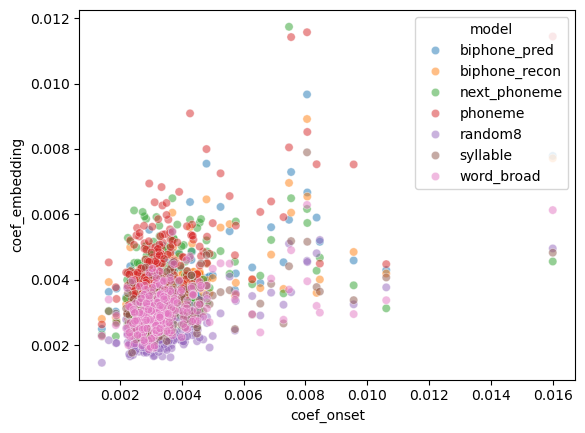

In [68]:
sns.scatterplot(data=onset_embedding_coef_norms.reset_index(),
                x="coef_onset", y="coef_embedding", hue="model",
                alpha=0.5)

In [69]:
onset_emb_correlations = onset_embedding_coef_norms \
    .groupby("model").apply(lambda df: pd.Series(spearmanr(df.coef_onset, df.coef_embedding), index=["rho", "pval"])) \
    .sort_values("rho")
onset_emb_correlations

,rho,pval
model,,
next_phoneme,0.222288,3.381715e-04
phoneme,0.340435,2.295446e-08
syllable,0.341959,1.968545e-08
word_broad,0.367615,1.304734e-09
biphone_recon,0.373320,6.901473e-10
biphone_pred,0.400883,2.658420e-11
random8,0.528070,8.725174e-20


## ERPs for top-explained electrodes

In [70]:
ttest_df.loc[dataset, subject]

/tmp/ipykernel_185243/1151158144.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  ttest_df.loc[dataset, subject]


output_dim.1 permutation       tval  \
model2        model1   output_dim                                        
biphone_pred  baseline 103                  103       shift  61.475630   
biphone_recon baseline 119                  119       shift  59.222644   
                       246                  246       shift  50.267099   
biphone_pred  baseline 119                  119       shift  47.020791   
next_phoneme  baseline 136                  136       shift  44.932607   
biphone_recon baseline 215                  215       shift  35.499163   
                       199                  199       shift  31.317099   
next_phoneme  baseline 215                  215       shift  30.052888   
biphone_recon baseline 62                    62       shift  28.670715   
biphone_pred  baseline 199                  199       shift  26.412890   
syllable      baseline 119                  119       units  23.615213   
phoneme       baseline 55                    55       shift  22.722388   
biphone_recon baseline 72                    72       shift  22.633641   
phoneme       baseline 199                  199       shift  22.531862   
biphone_recon baseline 205                  205       shift  20.661395   
biphone_pred  baseline 136                  136       shift  19.296772   
random8       baseline 119                  119       shift  18.983924   
phoneme       baseline 136                  136       shift  16.494500   
                       72                    72       shift  16.250922   
biphone_pred  baseline 71                    71       shift  15.814668   
next_phoneme  baseline 83                    83       shift  15.338933   
biphone_recon baseline 55                    55       shift  15.275454   
next_phoneme  baseline 10                    10       shift  14.754928   
biphone_recon baseline 232                  232       shift  14.738629   
phoneme       baseline 184                  184       shift  14.336702   
random8       baseline 212                  212       shift  13.556266   
biphone_recon baseline 210                  210       shift  13.251908   
phoneme       baseline 88                    88       shift  12.827486   
biphone_recon baseline 40                    40       shift  12.131986   
syllable      baseline 21                    21       units  11.884890   
phoneme       baseline 119                  119       shift  11.737672   
biphone_recon baseline 228                  228       shift  11.671887   
random8       baseline 250                  250       shift  11.618626   
next_phoneme  baseline 183                  183       shift  11.431077   
                       171                  171       shift  11.116821   
random8       baseline 40                    40       shift  10.887494   
next_phoneme  baseline 199                  199       shift  10.752586   
                       220                  220       shift  10.717072   
syllable      baseline 239                  239       units  10.418277   
                       20                    20       shift  10.312387   
                       184                  184       units  10.166932   
biphone_recon baseline 71                    71       shift   9.872412   
word_broad    baseline 152                  152       units   9.821851   
biphone_pred  baseline 72                    72       shift   9.668720   
biphone_recon baseline 136                  136       shift   9.108925   
biphone_pred  baseline 167                  167       shift   9.068840   
next_phoneme  baseline 71                    71       shift   9.058920   
                       17                    17       shift   8.910801   
biphone_pred  baseline 55                    55       shift   8.862232   
next_phoneme  baseline 85                    85       shift   8.695729   

                                           pval  log_pval  
model2        model1   output_dim                          
biphone_pred  baseline 103         4.193470e-07 -6.377426  
biphon

In [71]:
def plot_epochs(epochs_df, facet_kwargs=None):
    # Order columns by peak mean value
    col_order = epochs_df.groupby(["electrode_idx", "epoch_sample"]) \
        .value.mean().abs().groupby("electrode_idx").max() \
        .sort_values(ascending=False).index
    g = sns.relplot(data=epochs_df,
                    x="epoch_time", y="value", col="electrode_idx",
                    col_wrap=3, col_order=col_order, kind="line",
                    facet_kws={"sharex": False}, **(facet_kwargs or {}))

    # standard y-position for each model
    model_rect_size = 0.05
    get_model_position = lambda model_name: 0.1 + model_rect_size * sorted(encoder_names).index(model_name)

    for ax, electrode_idx in zip(g.axes.ravel(), col_order):
        ax.axvline(0, color="gray", linestyle="--")
        ax.axhline(0, color="gray", linestyle="--")

        # which models show significant prediction of this electrode?
        for model_name, log_pval_i in log_pvals[electrode_idx].items():
            alpha = 0.05 if log_pval_i == 0 else 0.8
            rect = plt.Rectangle((0.05, get_model_position(model_name)), model_rect_size, model_rect_size,
                                  color=get_model_color(model_name), alpha=alpha, transform=ax.transAxes)
            
            if log_pval_i != 0:
                # annotate with score
                ax.text(0.12, get_model_position(model_name), f"{np.power(10, log_pval_i):.1g}",
                        verticalalignment="bottom", alpha=0.8,
                        transform=ax.transAxes)
            ax.add_patch(rect)
            
    # add a model legend above the top of the facet grid
    legend_ax = g.fig.add_axes([0.1, 1.0, 0.8, 0.05])
    legend_ax.axis("off")
    for model_name in encoder_names:
        legend_ax.add_patch(plt.Rectangle((0.75 * model_rect_size, get_model_position(model_name)), model_rect_size, model_rect_size,
                                        color=get_model_color(model_name), alpha=0.8, transform=legend_ax.transAxes))
        legend_ax.text(0.1, get_model_position(model_name), model_name, verticalalignment="bottom",
                    transform=legend_ax.transAxes)
        
    return g

### Trial onset ERP for top-explained electrodes

/tmp/ipykernel_185243/3746184206.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  plot_epoch_electrodes = ttest_df.loc[dataset, subject].index.get_level_values("output_dim").unique()


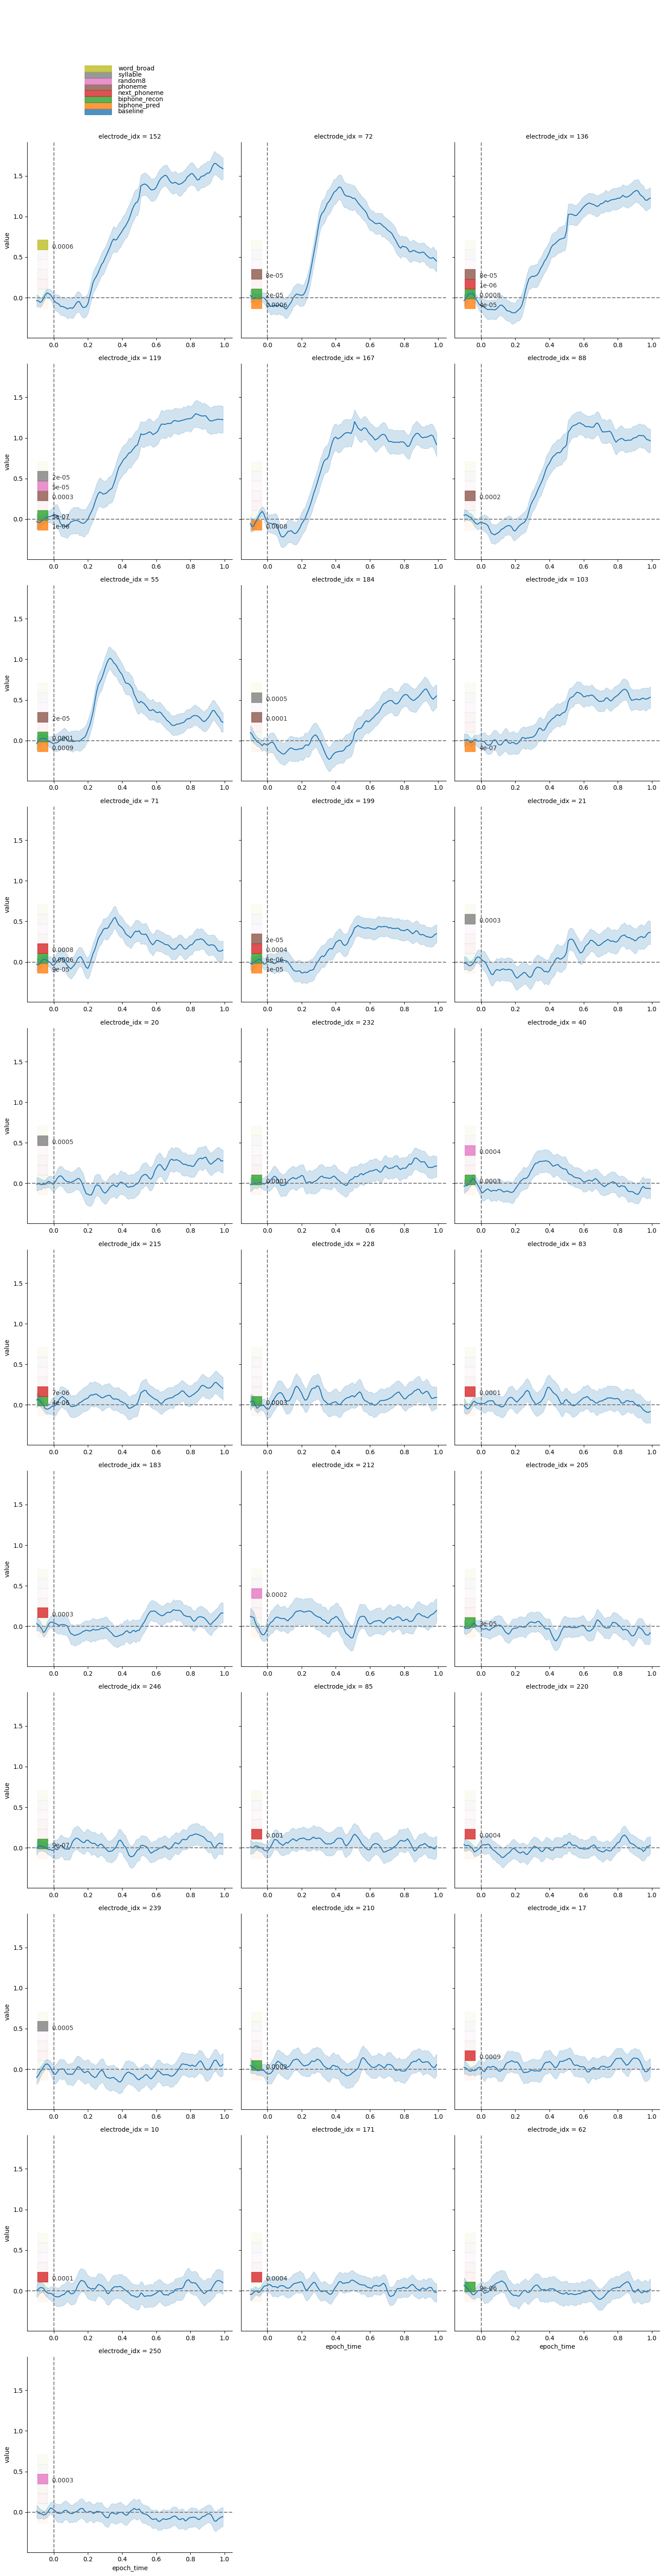

In [72]:
plot_epoch_electrodes = ttest_df.loc[dataset, subject].index.get_level_values("output_dim").unique()
plot_trial_epochs = trial_epochs[trial_epochs.electrode_idx.isin(plot_epoch_electrodes)]
plot_epochs(plot_trial_epochs)

### Word onset ERP for top-explained electrodes

In [73]:
word_epochs = epoch_by_state_space(
    aligned, "word",
    subset_electrodes=plot_epoch_electrodes,
    epoch_window=(-0.1, 0.3),
    baseline_window=(-0.1, 0.),
    return_df=True)

  0%|          | 0/3052 [00:00<?, ?it/s]

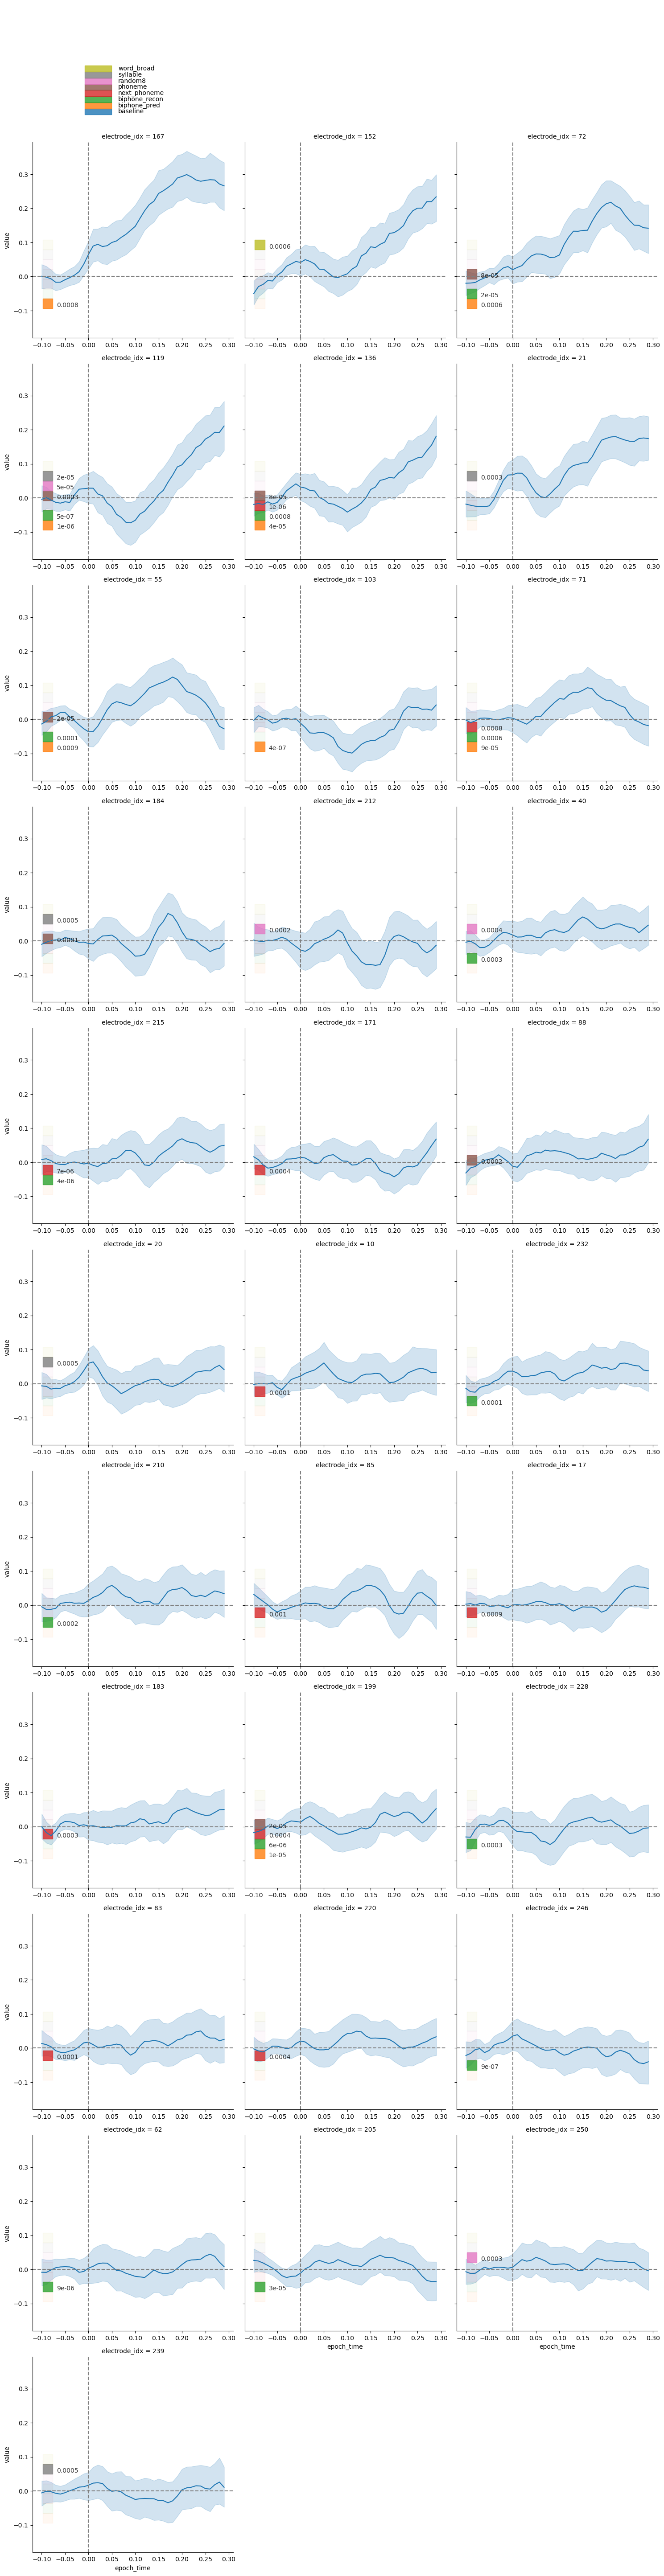

In [74]:
plot_epochs(word_epochs)